In [5]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.autograd import Variable
import glob
import os
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import sys
import torch.utils.data
from torchvision import models
# from torch.summary import summary

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.is_available()

In [ ]:
#LOAD DATA

# parameters:
positive_class_label = 3
# Hyper-parameters #1
batch_size = 100 # big batches
validation_split = .2
random_seed= 42
shuffle_dataset = True

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train = True, transform = transforms.ToTensor(), download = True)
train_batch_qty = math.ceil(len(train_dataset)/batch_size)
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())
test_batch_qty = math.ceil(len(test_dataset)/batch_size)

# Data loader
train_dl = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = shuffle_dataset)
test_dl = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

dataset_num_classes = 10
dataset_input_size = 28 * 28 

In [ ]:

class NClases(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): # new parameter: num_classes
        super(NClases, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() 
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [ ]:
# DEFINE MODEL

# Hyper-parameters #2
input_size = dataset_input_size 
hidden_size = 500 
num_classes = dataset_num_classes
print(f'input_size:{input_size}, hidden_size:{hidden_size}, num_classes:{num_classes}')

num_epochs = 10
learning_rate = 0.001


model = NClases(input_size, hidden_size, num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

In [ ]:
from tqdm.notebook import tqdm
import sys

In [ ]:
def train(model, device, train_dl, optimizer):
    #set model in train() mode:
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for i, (inputs, targets) in tqdm(enumerate(train_dl), total=train_batch_qty, desc='Training minibatch loop '):
        inputs, targets = inputs.to(device), targets.to(device)        
        inputs = inputs.reshape(-1, 28*28).to(device)
#         print(inputs.size(), targets.size(), targets)
#         assert False
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze()) 
        
        # Backward and optimize        
        # zero grad before new step        
        optimizer.zero_grad()                        
        loss.backward()
        optimizer.step()   

        # calculating the total_loss for checking
        total_loss += loss           
        
        # PREDICTIONS 
        total_samples += targets.shape[0]   
        _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
        correct_samples += torch.sum(predictions_indices==targets)
#         if i == 0:
#             print(f'outputs: {outputs}, predictions_indices:{predictions_indices}, \
#             targets:{targets}, correct_samples:{correct_samples}, total_samples: {total_samples}')        
        
    train_accuracy = float(correct_samples) / total_samples        
    
    return total_loss, train_accuracy                        

In [ ]:
# TESTING THE MODEL
def test(model, device, test_dl):
    #set model in eval() mode (it skips Dropout etc):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0 
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(test_dl), total=test_batch_qty, desc='Testing minibatch loop:'):
            #LOAD THE DATA IN A BATCH                       
            inputs, targets = inputs.to(device), targets.to(device)        
            inputs = inputs.reshape(-1, 28*28).to(device)            
                       
            # apply model to input data
            outputs = model(inputs)        
                       
            #PREDICTIONS
            total_samples += targets.shape[0]   
            _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
            correct_samples += torch.sum(predictions_indices==targets)                    
        
    test_accuracy = correct_samples / total_samples        
    
    return test_accuracy              

In [ ]:
%%time
for_losses = []
n_total_steps = len(train_dl)

for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer)
    test_accuracy = test(model, device, test_dl)
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

In [ ]:
plt.plot(np.arange(len(for_losses)), for_losses)

In [ ]:
for_test = np.random.randint(len(test_dataset), size=5)

In [ ]:
data = test_dataset.data.reshape(-1,28*28).float().to(device)
targets = test_dataset.targets.to(device)

In [ ]:
data[for_test]

In [ ]:
torch.max(model(data[for_test]), 1)

In [ ]:
targets[for_test]

In [ ]:
heat_map_matrix = np.zeros((10, 10))
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in zip(test_dataset.data, test_dataset.targets):
        images = images.reshape(-1, 28*28).float().to(device)
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
        heat_map_matrix[labels.cpu()][predicted.cpu()] += 1
        print(predicted)

In [ ]:
import seaborn as sns
import pandas as pd
heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=test_dataset.classes)
heat_map_matrix.index = test_dataset.classes
plt.figure(1, (15, 10))
sns.heatmap(heat_map_matrix, annot=True, fmt='g')
plt.show()

In [ ]:
torch.save(model, 'modelka.pt')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.is_available()

In [ ]:
#LOAD DATA

# Hyper-parameters #1
batch_size = 100 # big batches
shuffle_dataset = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 

# MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train = True, transform = trans, download = True)
train_batch_qty = math.ceil(len(train_dataset)/batch_size)
test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False, transform = trans)
test_batch_qty = math.ceil(len(test_dataset)/batch_size)

# Data loader
train_dl = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = shuffle_dataset)
test_dl = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

dataset_num_classes = 10
dataset_input_size = 28 * 28

In [ ]:

class ConvNet(nn.Module):
    def __init__(self): # new parameter: num_classes
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(7 * 7 * 64, 1000) 
        self.fc2 = nn.Linear(1000, 10)
        
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

In [ ]:
num_epochs = 5 
num_classes = 10
learning_rate = 0.001

In [ ]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_step = len(train_dl)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):
        # Прямой запуск
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=transforms.ToTensor())

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [ ]:
train_batch_qty = math.ceil(len(trainset)/batch_size)
test_batch_qty = math.ceil(len(testset)/batch_size)

In [ ]:
img, label = dataset[0]
img_shape = img.shape
img_shape

In [ ]:
classes = dataset.classes
classes, len(classes)

In [ ]:
input_size = 3*32*32
num_classes = 10

In [ ]:
# DEFINE MODEL

# Hyper-parameters #2
hidden_size = 3*33*33
print(f'input_size:{input_size}, hidden_size:{hidden_size}, num_classes:{num_classes}')

num_epochs = 10
learning_rate = 0.001


model = CIFAR10Model(input_size, hidden_size, num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

In [ ]:
def train1(model, device, train_dl, optimizer):
    #set model in train() mode:
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for i, (inputs, targets) in tqdm(enumerate(train_dl), total=train_batch_qty, desc='Training minibatch loop '):
        inputs, targets = inputs.to(device), targets.to(device)        
        inputs = inputs.reshape(-1, 3*32*32).to(device)
#         print(inputs.size(), targets.size(), targets)
#         assert False
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze()) 
        
        # Backward and optimize        
        # zero grad before new step        
        optimizer.zero_grad()                        
        loss.backward()
        optimizer.step()   

        # calculating the total_loss for checking
        total_loss += loss           
        
        # PREDICTIONS 
        total_samples += targets.shape[0]   
        _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
        correct_samples += torch.sum(predictions_indices==targets)
#         if i == 0:
#             print(f'outputs: {outputs}, predictions_indices:{predictions_indices}, \
#             targets:{targets}, correct_samples:{correct_samples}, total_samples: {total_samples}')        
        
    train_accuracy = float(correct_samples) / total_samples        
    
    return total_loss, train_accuracy                        

In [ ]:
# TESTING THE MODEL
def test1(model, device, test_dl):
    #set model in eval() mode (it skips Dropout etc):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0 
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(test_dl), total=test_batch_qty, desc='Testing minibatch loop:'):
            #LOAD THE DATA IN A BATCH                       
            inputs, targets = inputs.to(device), targets.to(device)        
            inputs = inputs.reshape(-1, 3*32*32).to(device)            
                       
            # apply model to input data
            outputs = model(inputs)        
                       
            #PREDICTIONS
            total_samples += targets.shape[0]   
            _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
            correct_samples += torch.sum(predictions_indices==targets)                    
        
    test_accuracy = correct_samples / total_samples        
    
    return test_accuracy              

In [ ]:
%%time
for_losses = []
n_total_steps = len(trainloader)

for epoch in range(num_epochs):
    total_loss, train_accuracy = train1(model, device, trainloader, optimizer)
    test_accuracy = test1(model, device, testloader)
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                 

In [ ]:
plt.plot(np.arange(len(for_losses)), for_losses)

In [ ]:
for_test = np.random.randint(len(test_dataset), size=5)

In [ ]:
data = test_dataset.data.reshape(-1,28*28).float().to(device)
targets = test_dataset.targets.to(device)

In [ ]:
data[for_test]

In [ ]:
torch.max(model(data[for_test]), 1)

In [ ]:
targets[for_test]

In [ ]:
heat_map_matrix = np.zeros((10, 10))
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in zip(test_dataset.data, test_dataset.targets):
        images = images.reshape(-1, 28*28).float().to(device)
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
        heat_map_matrix[labels.cpu()][predicted.cpu()] += 1
        print(predicted)

In [ ]:
import seaborn as sns
import pandas as pd
heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=test_dataset.classes)
heat_map_matrix.index = test_dataset.classes
plt.figure(1, (15, 10))
sns.heatmap(heat_map_matrix, annot=True, fmt='g')
plt.show()

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=transforms.ToTensor())

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [ ]:
dataiter = iter(trainloader); dataiter
images, labels = dataiter.next()

In [ ]:
images, labels

In [ ]:
train_batch_qty = math.ceil(len(trainset)/batch_size)
test_batch_qty = math.ceil(len(testset)/batch_size)

In [ ]:
num_epochs = 5 
num_classes = 10
learning_rate = 0.001

In [ ]:
class CIFAR10Model(nn.Module):
    def __init__(self): # new parameter: num_classes
        super(CIFAR10Model, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(8 * 8 * 64, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out)
        out = self.fc2(out) 
        return out

In [ ]:
model = CIFAR10Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_step = len(trainloader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Прямой запуск
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [6]:
DATA_DIR = 'C:/Users/nabr9/Documents/monkeys'

TRAIN_DIR = DATA_DIR + '/training/training/'                           
VAL_DIR = DATA_DIR + '/validation/validation/'                             
LABEL_FIL=DATA_DIR +"/monkey_labels.txt"

In [7]:
train_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

valid_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
train_ds = ImageFolder ( TRAIN_DIR , transform = train_tfms)
val_ds = ImageFolder ( VAL_DIR , transform = valid_tfms)

In [9]:
batch_size = 16

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size,
                        num_workers=4, pin_memory=True)

In [11]:
math.ceil(len(train_ds)/batch_size)

69

In [12]:
math.ceil(len(val_ds)/batch_size)

17

In [13]:
def train(model, device, train_dl, optimizer, total):
    #set model in train() mode:
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for i, (inputs, targets) in tqdm(enumerate(train_dl), total= total, desc='Training minibatch loop '):

        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())
        
        # Backward and optimize        
        # zero grad before new step        
        optimizer.zero_grad()                        
        loss.backward()
        optimizer.step()   

        # calculating the total_loss for checking
        total_loss += loss           
        
        # PREDICTIONS 
        total_samples += targets.shape[0]   
        _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
        correct_samples += torch.sum(predictions_indices==targets)

    train_accuracy = float(correct_samples) / total_samples        
    
    return total_loss, train_accuracy                        

In [14]:
# TESTING THE MODEL
def test(model, device, test_dl, total):
    #set model in eval() mode (it skips Dropout etc):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0 
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(test_dl), total=total, desc='Testing minibatch loop:'):       
                       
            # apply model to input data
            outputs = model(inputs)        
                       
            #PREDICTIONS
            total_samples += targets.shape[0]   
            _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
            correct_samples += torch.sum(predictions_indices==targets)                    
        
    test_accuracy = correct_samples / total_samples        
    
    return test_accuracy              

In [15]:
class MonkeyModel(nn.Module):
    def __init__(self):
        super(MonkeyModel, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 9, kernel_size=5, stride=1, padding = 1), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(9, 16, kernel_size=5, stride=1, padding = 1), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(16, 32, kernel_size=5, stride=1, padding = 1),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3200, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [16]:
num_epochs = 15
num_classes = 10
learning_rate = 0.001

In [17]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  2% | 10% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% | 11% |


In [18]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [20]:
model = MonkeyModel()
model = to_device(model, device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   

In [22]:
%%time
for_losses = []
n_total_steps = len(train_dl)


for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer, total = math.ceil(len(train_ds)/batch_size))
    test_accuracy = test(model, device, val_dl, total = math.ceil(len(val_ds)/batch_size))
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1/15], Loss: 131.4127, Train acc: 0.3099, Test acc: 0.4485


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/15], Loss: 101.6406, Train acc: 0.4722, Test acc: 0.4632


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/15], Loss: 86.3110, Train acc: 0.5542, Test acc: 0.5662


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/15], Loss: 76.7256, Train acc: 0.6217, Test acc: 0.5257


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/15], Loss: 66.5421, Train acc: 0.6773, Test acc: 0.6213


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/15], Loss: 53.2609, Train acc: 0.7366, Test acc: 0.5441


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/15], Loss: 47.6544, Train acc: 0.7566, Test acc: 0.5588


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/15], Loss: 41.5808, Train acc: 0.7867, Test acc: 0.6287


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/15], Loss: 34.8441, Train acc: 0.8122, Test acc: 0.5846


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/15], Loss: 30.3261, Train acc: 0.8478, Test acc: 0.5735


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11/15], Loss: 28.5383, Train acc: 0.8541, Test acc: 0.6103


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12/15], Loss: 20.7399, Train acc: 0.8970, Test acc: 0.6213


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13/15], Loss: 23.8917, Train acc: 0.8897, Test acc: 0.6324


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14/15], Loss: 14.3577, Train acc: 0.9253, Test acc: 0.6213


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15/15], Loss: 17.2514, Train acc: 0.9134, Test acc: 0.6434
Wall time: 3min 33s


In [23]:
def prediction(images, model):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    prediction = list(categories)[preds[0].item()]
    return prediction

In [24]:
categories = {
    
    "mantled_howler":0,
    "patas_monkey":1,
    "bald_uakari":2,
    "japanese_macaque":3,
    "pygmy_marmoset":4,
    "white_headed_capuchin":5,
    "silvery_marmoset":6,
    "common_squirrel_monkey":7,
    "black_headed_night_monkey":8,
    "nilgiri_langur":9
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: mantled_howler
Prediction: mantled_howler


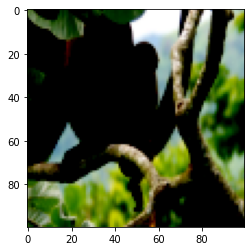

In [25]:
images, labels = val_ds[20]
print("Label:", list(categories)[labels])
print("Prediction:", prediction(images, model))
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: common_squirrel_monkey
Prediction: common_squirrel_monkey


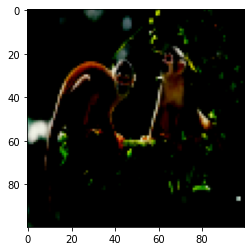

In [26]:
images, labels = val_ds[200]
print("Label:", list(categories)[labels])
print("Prediction:", prediction(images, model))
plt.imshow(images.permute(1,2,0))

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [2]:
DATA_DIR = 'C:/Users/nabr9/Documents/catsdogs'

TRAIN_DIR = DATA_DIR + '/train/'

In [ ]:
# def load_images_from_folder(folder,only_path = False, label = ""):
#     if only_path == False:
#         images = []
#         file_name=[]
#         for filename in os.listdir(folder):
#             img = plt.imread(os.path.join(folder,filename))
            
#             if img is not None:
#                 end=filename.find(".")
#                 file_name.append(file[0:end])
#                 images.append(img)
                
#         return images, file_name
#     else:
#         path = []
#         for filename in os.listdir(folder):
#             img_path = os.path.join(folder,filename)
#             if img_path is not None:
#                 path.append([label,img_path])
#         return path

In [ ]:
# images = []
# path = TRAIN_DIR
# for f in os.listdir(path):
#     if "jpg" in os.listdir(path+f)[0]:
#         images += load_images_from_folder(path+f,True,label = f)
      
#     else: 
#         for d in os.listdir(path+f):
#             images += load_images_from_folder(path+f+"/"+d,True,label = f)
            
                        
# # Create a dataframe with the paths and the label for each monkey species
# train_df = pd.DataFrame(images, columns = ["animal_class", "path_img"])
# train_len=len(train_df["path_img"])


In [ ]:
# train_df

In [3]:
train_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

valid_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_ds = ImageFolder (TRAIN_DIR , transform = train_tfms)

In [5]:
test_set_size = int(len(train_ds) * 0.8)
valid_set_size = len(train_ds) - test_set_size
_, valid_ds = torch.utils.data.random_split(train_ds, [test_set_size, valid_set_size])

In [6]:
batch_size = 16

In [7]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(valid_ds, batch_size,
                        num_workers=4, pin_memory=True)

In [8]:
math.ceil(len(train_ds)/batch_size)

1563

In [9]:
math.ceil(len(valid_ds)/batch_size)

313

In [17]:
class DogsCatsModel(nn.Module):
    def __init__(self):
        super(DogsCatsModel, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 9, kernel_size=5, stride=1, padding = 1), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(9, 16, kernel_size=5, stride=1, padding = 1), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(16, 32, kernel_size=5, stride=1, padding = 1),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3200, 1000)
        self.fc2 = nn.Linear(1000, 2)
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [13]:
num_epochs = 10
num_classes = 2
learning_rate = 0.001

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [18]:
model = DogsCatsModel()
model = to_device(model, device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   

In [20]:
%%time
for_losses = []
n_total_steps = len(train_dl)


for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer, total = math.ceil(len(train_ds)/batch_size))
    test_accuracy = test(model, device, val_dl, total = math.ceil(len(valid_ds)/batch_size))
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1000.8884, Train acc: 0.6296, Test acc: 0.7206


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/10], Loss: 855.7239, Train acc: 0.7244, Test acc: 0.7738


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/10], Loss: 766.5944, Train acc: 0.7668, Test acc: 0.7992


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/10], Loss: 721.3104, Train acc: 0.7817, Test acc: 0.8204


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/10], Loss: 694.3309, Train acc: 0.7968, Test acc: 0.8298


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/10], Loss: 671.0231, Train acc: 0.8030, Test acc: 0.8380


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/10], Loss: 662.5340, Train acc: 0.8060, Test acc: 0.8130


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/10], Loss: 648.3226, Train acc: 0.8098, Test acc: 0.8328


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/10], Loss: 624.7253, Train acc: 0.8201, Test acc: 0.8502


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/10], Loss: 618.2356, Train acc: 0.8210, Test acc: 0.8456
Wall time: 4min 43s


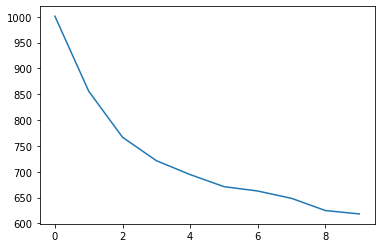

In [21]:
plt.plot(np.arange(len(for_losses)), for_losses)

In [ ]:
# for_test = np.random.randint(len(valid_ds), size=5)

In [ ]:
# data = valid_ds.data.reshape(-1,100).float().to(device)
# targets = test_dataset.targets.to(device)

In [ ]:
# data[for_test]

In [ ]:
# torch.max(model(data[for_test]), 1)

In [ ]:
# targets[for_test]

In [ ]:
# heat_map_matrix = np.zeros((10, 10))
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in zip(test_dataset.data, test_dataset.targets):
#         images = images.reshape(-1, 28*28).float().to(device)
#         labels = labels
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         correct += (predicted.to(device) == labels.to(device)).sum().item()
#         heat_map_matrix[labels.cpu()][predicted.cpu()] += 1
#         print(predicted)

In [ ]:
# import seaborn as sns
# import pandas as pd
# heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=test_dataset.classes)
# heat_map_matrix.index = test_dataset.classes
# plt.figure(1, (15, 10))
# sns.heatmap(heat_map_matrix, annot=True, fmt='g')
# plt.show()

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [1]:
DATA_DIR = 'C:/Users/nabr9/Documents/monkeys'

TRAIN_DIR = DATA_DIR + '/training/training/'                           
VAL_DIR = DATA_DIR + '/validation/validation/'                             
LABEL_FIL=DATA_DIR +"/monkey_labels.txt"

In [4]:
train_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

valid_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
train_ds = ImageFolder ( TRAIN_DIR , transform = train_tfms)
val_ds = ImageFolder ( VAL_DIR , transform = valid_tfms)

In [19]:
batch_size = 16

In [7]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 16, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = 16,
                        num_workers=4, pin_memory=True)

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [11]:
vgg16 = models.vgg16(pretrained=True)

In [12]:
for param in vgg16.features.parameters():
    param.requires_grad = False 
vgg16.classifier[6].out_features = 10
vgg16 = to_device(vgg16, device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [21]:
num_epochs = 15

In [22]:
%%time
for_losses = []
n_total_steps = len(train_dl)


for epoch in range(num_epochs):
    total_loss, train_accuracy = train(vgg16, device, train_dl, optimizer, total = math.ceil(len(train_ds)/batch_size))
    test_accuracy = test(vgg16, device, val_dl, total = math.ceil(len(val_ds)/batch_size))
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1/15], Loss: 13.0714, Train acc: 0.9490, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/15], Loss: 3.8983, Train acc: 0.9863, Test acc: 0.9743


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/15], Loss: 1.6199, Train acc: 0.9954, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/15], Loss: 1.3731, Train acc: 0.9945, Test acc: 0.9743


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/15], Loss: 1.3639, Train acc: 0.9945, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/15], Loss: 1.2030, Train acc: 0.9964, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/15], Loss: 0.5368, Train acc: 0.9982, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/15], Loss: 0.7827, Train acc: 0.9991, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/15], Loss: 0.7139, Train acc: 0.9964, Test acc: 0.9890


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/15], Loss: 0.3750, Train acc: 0.9991, Test acc: 0.9853


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11/15], Loss: 0.4758, Train acc: 0.9982, Test acc: 0.9853


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12/15], Loss: 0.3570, Train acc: 1.0000, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13/15], Loss: 0.3351, Train acc: 0.9991, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14/15], Loss: 0.4523, Train acc: 0.9991, Test acc: 0.9853


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15/15], Loss: 0.3513, Train acc: 0.9982, Test acc: 0.9890
Wall time: 3min 44s


In [23]:
vgg16 = models.vgg16(pretrained=True)

In [24]:
for param in vgg16.features.parameters():
    param.requires_grad = True
vgg16.classifier[6].out_features = 10
vgg16 = to_device(vgg16, device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [27]:
%%time
for_losses = []
n_total_steps = len(train_dl)


for epoch in range(num_epochs):
    total_loss, train_accuracy = train(vgg16, device, train_dl, optimizer, total = math.ceil(len(train_ds)/batch_size))
    test_accuracy = test(vgg16, device, val_dl, total = math.ceil(len(val_ds)/batch_size))
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1/15], Loss: 210.8528, Train acc: 0.5397, Test acc: 0.9522


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/15], Loss: 11.3171, Train acc: 0.9562, Test acc: 0.9669


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/15], Loss: 4.1110, Train acc: 0.9818, Test acc: 0.9706


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/15], Loss: 2.7364, Train acc: 0.9881, Test acc: 0.9706


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/15], Loss: 2.1063, Train acc: 0.9927, Test acc: 0.9853


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/15], Loss: 1.2664, Train acc: 0.9973, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/15], Loss: 0.7441, Train acc: 0.9982, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/15], Loss: 0.6890, Train acc: 0.9973, Test acc: 0.9779


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/15], Loss: 0.3548, Train acc: 1.0000, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/15], Loss: 0.3934, Train acc: 0.9991, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11/15], Loss: 0.4217, Train acc: 0.9991, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12/15], Loss: 0.2324, Train acc: 1.0000, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13/15], Loss: 0.2467, Train acc: 1.0000, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14/15], Loss: 0.2134, Train acc: 1.0000, Test acc: 0.9816


Training minibatch loop :   0%|          | 0/69 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15/15], Loss: 0.2485, Train acc: 1.0000, Test acc: 0.9816
Wall time: 4min 33s


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


In [7]:
DATA_DIR = 'C:/Users/nabr9/Documents/catsdogs'

TRAIN_DIR = DATA_DIR + '/train/'

In [8]:
train_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

valid_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [9]:
train_ds = ImageFolder (TRAIN_DIR , transform = train_tfms)

In [10]:
test_set_size = int(len(train_ds) * 0.8)
valid_set_size = len(train_ds) - test_set_size
_, valid_ds = torch.utils.data.random_split(train_ds, [test_set_size, valid_set_size])

In [11]:
batch_size = 16

In [12]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_dl = torch.utils.data.DataLoader(valid_ds, batch_size,
                        num_workers=4, pin_memory=True)

In [13]:
math.ceil(len(train_ds)/batch_size)

1563

In [14]:
math.ceil(len(valid_ds)/batch_size)

313

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

for param in model_ft.parameters():
    param.requires_grad = True
model = to_device(model_ft, device)

In [20]:
%%time
for_losses = []
n_total_steps = len(train_dl)


for epoch in range(15):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer, total = math.ceil(len(train_ds)/batch_size))
    test_accuracy = test(model, device, val_dl, total = math.ceil(len(valid_ds)/batch_size))
    for_losses.append(total_loss.cpu().detach().numpy())
    print (f'Epoch [{epoch+1}/{15}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')     

Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/15], Loss: 55.1785, Train acc: 0.9872, Test acc: 0.9988


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/15], Loss: 27.6733, Train acc: 0.9942, Test acc: 0.9986


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/15], Loss: 18.2230, Train acc: 0.9962, Test acc: 0.9998


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/15], Loss: 10.4604, Train acc: 0.9983, Test acc: 1.0000


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/15], Loss: 8.6708, Train acc: 0.9986, Test acc: 0.9994


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/15], Loss: 6.2065, Train acc: 0.9991, Test acc: 1.0000


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/15], Loss: 7.5234, Train acc: 0.9987, Test acc: 0.9996


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/15], Loss: 3.5982, Train acc: 0.9996, Test acc: 1.0000


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/15], Loss: 2.1494, Train acc: 0.9997, Test acc: 1.0000


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/15], Loss: 1.1297, Train acc: 0.9998, Test acc: 0.9998


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [11/15], Loss: 1.6598, Train acc: 0.9997, Test acc: 1.0000


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [12/15], Loss: 1.8702, Train acc: 0.9997, Test acc: 0.9998


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [13/15], Loss: 7.5949, Train acc: 0.9993, Test acc: 0.9998


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [14/15], Loss: 0.9475, Train acc: 0.9999, Test acc: 0.9998


Training minibatch loop :   0%|          | 0/1563 [00:00<?, ?it/s]

Testing minibatch loop::   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [15/15], Loss: 0.8588, Train acc: 0.9999, Test acc: 0.9998
Wall time: 14min 14s
